In [1]:
pip install torch

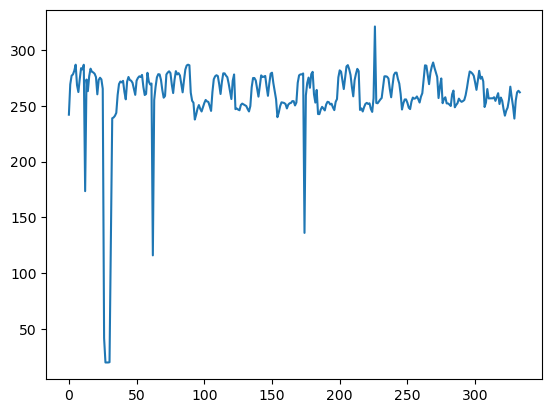

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
 
df = pd.read_csv('project_a.csv')
timeseries = df[["cost"]].values.astype('float32')
 
plt.plot(timeseries)
plt.show()

In [2]:
timeseries

array([[242.01768 ],
       [269.1615  ],
       [276.9207  ],
       [278.11658 ],
       [281.4511  ],
       [286.78635 ],
       [268.44675 ],
       [262.30774 ],
       [273.80484 ],
       [283.66144 ],
       [282.57953 ],
       [286.73892 ],
       [173.49794 ],
       [273.49075 ],
       [263.06818 ],
       [276.6031  ],
       [283.23276 ],
       [280.50443 ],
       [279.8694  ],
       [278.7094  ],
       [275.6837  ],
       [260.25415 ],
       [273.1575  ],
       [275.10645 ],
       [273.61893 ],
       [265.22095 ],
       [ 41.755375],
       [ 19.99986 ],
       [ 20.      ],
       [ 19.999996],
       [ 20.251472],
       [125.516106],
       [238.79459 ],
       [239.48817 ],
       [241.00174 ],
       [243.65944 ],
       [259.67093 ],
       [269.42615 ],
       [271.72803 ],
       [270.94183 ],
       [272.3237  ],
       [262.43787 ],
       [255.77838 ],
       [271.669   ],
       [275.79193 ],
       [273.09424 ],
       [272.41968 ],
       [270.5

In [3]:
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

In [4]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=12, num_layers=1, batch_first=True)
        self.linear = nn.Linear(12, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [5]:
lookback = 12

In [6]:
# train-test split for time series
train_size = int(len(timeseries[:304-lookback-15]))
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]
print(train_size, test_size)

277 57


In [7]:
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)

C:\Users\Jackyfirst\AppData\Local\Temp\ipykernel_12796\778121417.py:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:248.)
  return torch.tensor(X), torch.tensor(y)


In [8]:
import numpy as np
import torch.optim as optim
import torch.utils.data as data

model = Model()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)
 
n_epochs = 3000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 260.6084, test RMSE 260.0360
Epoch 100: train RMSE 216.3735, test RMSE 215.2578
Epoch 200: train RMSE 176.3315, test RMSE 174.5974
Epoch 300: train RMSE 137.2066, test RMSE 134.7612
Epoch 400: train RMSE 99.5707, test RMSE 96.1572
Epoch 500: train RMSE 64.9110, test RMSE 59.9357
Epoch 600: train RMSE 37.8894, test RMSE 30.0732
Epoch 700: train RMSE 28.3852, test RMSE 19.2736
Epoch 800: train RMSE 25.9808, test RMSE 15.5105
Epoch 900: train RMSE 24.9822, test RMSE 14.0714
Epoch 1000: train RMSE 24.6454, test RMSE 13.5107
Epoch 1100: train RMSE 24.3082, test RMSE 12.8953
Epoch 1200: train RMSE 23.9858, test RMSE 12.4327
Epoch 1300: train RMSE 23.7596, test RMSE 11.9185
Epoch 1400: train RMSE 22.7900, test RMSE 9.9742
Epoch 1500: train RMSE 22.1657, test RMSE 8.7266
Epoch 1600: train RMSE 21.9461, test RMSE 8.0905
Epoch 1700: train RMSE 21.8487, test RMSE 7.8063
Epoch 1800: train RMSE 21.7528, test RMSE 7.5785
Epoch 1900: train RMSE 21.8063, test RMSE 7.7834
Epoch 2000

In [9]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]

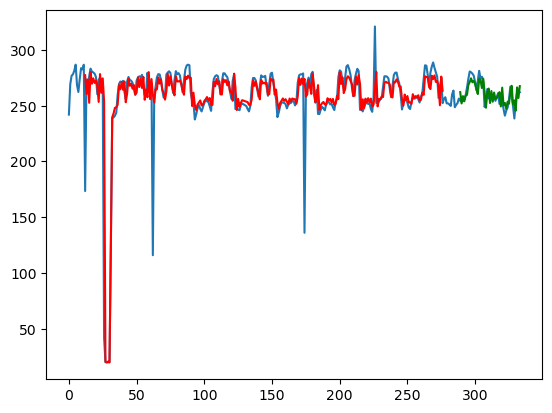

In [10]:
# plot
plt.plot(timeseries)
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()

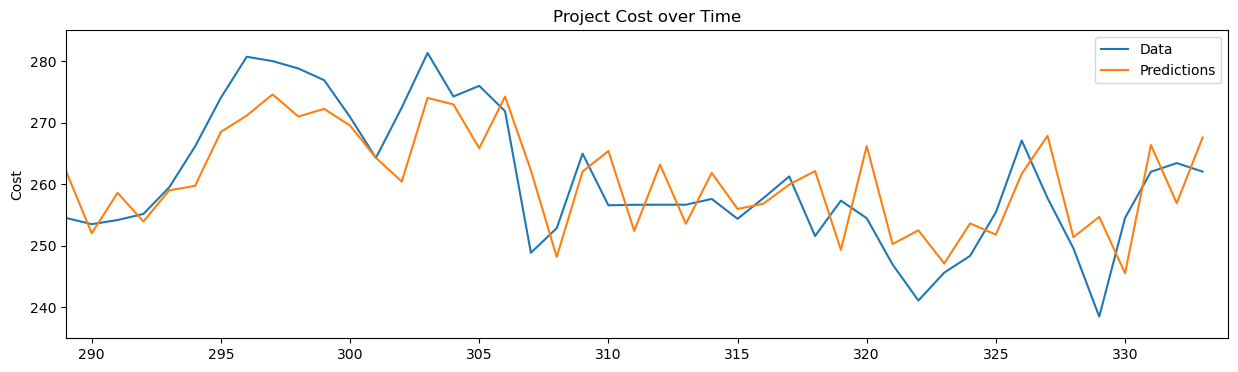

In [11]:
# plot
plt.figure(figsize=(15,4))
plt.plot(timeseries)
plt.plot(test_plot)
plt.legend(('Data', 'Predictions'))
plt.title('Project Cost over Time')
plt.ylabel('Cost')
plt.xlim(train_size + lookback, len(timeseries))
plt.ylim(235, 285)
plt.show()